In [1]:
import webdataset as wds
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import torch
import torch.nn as nn
import pandas as pd

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
coco73k = np.load('../naturalscenesdataset/COCO_73k_annots.npy')
coco73k_curated = np.load('../naturalscenesdataset/COCO_73k_annots_curated.npy')

In [4]:
data_path='../naturalscenesdataset/webdataset_avg_split/'
subj = 1

In [5]:
if subj == 1:
    num_voxels = 15724
elif subj == 2:
    num_voxels = 14278
elif subj == 3:
    num_voxels = 15226
elif subj == 4:
    num_voxels = 13153
elif subj == 5:
    num_voxels = 13039
elif subj == 6:
    num_voxels = 17907
elif subj == 7:
    num_voxels = 12682
elif subj == 8:
    num_voxels = 14386

### Loading Dataset 

In [6]:
train_url = f"{data_path}train/train_subj0{subj}_" + "{0..17}.tar"
test_url = f"{data_path}test/test_subj0{subj}_" + "{0..1}.tar"

meta_url = f"{data_path}metadata_subj0{subj}.json"
num_train = 8559 + 300
num_val = 982
batch_size = 32
voxels_key = 'nsdgeneral.npy' # 1d inputs

train_data = wds.WebDataset(train_url, resampled=False)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")\
    .batched(batch_size, partial=False)

test_data = wds.WebDataset(test_url, resampled=False)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")\
    .batched(batch_size, partial=False)

train_dl = torch.utils.data.DataLoader(train_data, batch_size=None, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_data, batch_size=None, shuffle=False)

# check that your data loader is working
for train_i, (voxel, img_input, coco) in enumerate(train_dl):
    print("idx",train_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    print("coco.shape",coco.shape)
    break

idx 0
voxel.shape torch.Size([32, 3, 15724])
img_input.shape torch.Size([32, 3, 256, 256])
coco.shape torch.Size([32, 1])


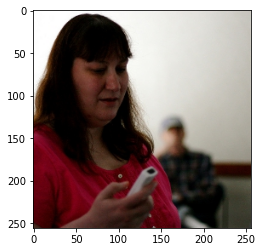

['A woman that is looking at a white remote.']


In [7]:
plt.imshow(np.transpose(img_input[0], (1, 2, 0)))
plt.show()
print(coco73k[coco][0])

### Similarity Analysis 

#### PWCCA 

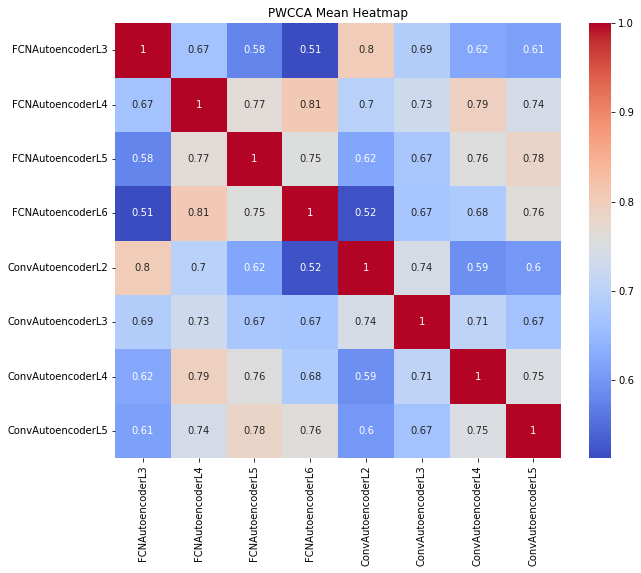

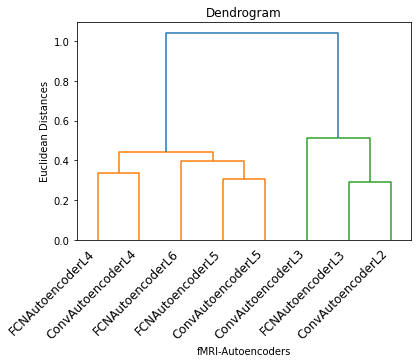

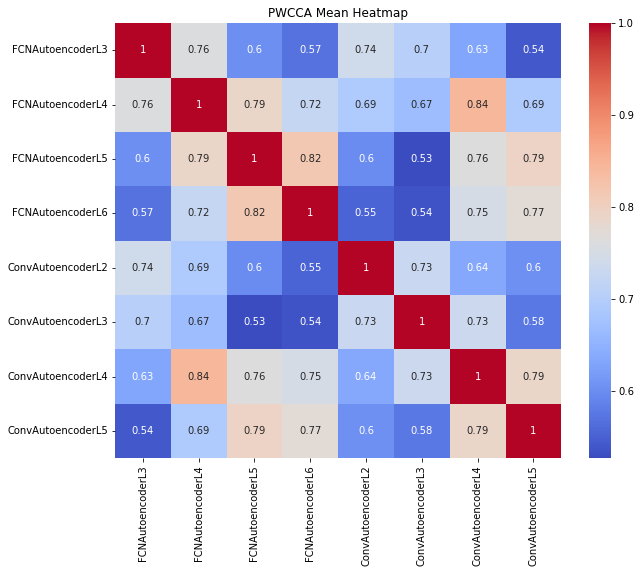

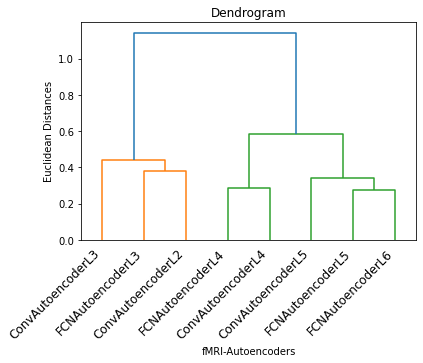

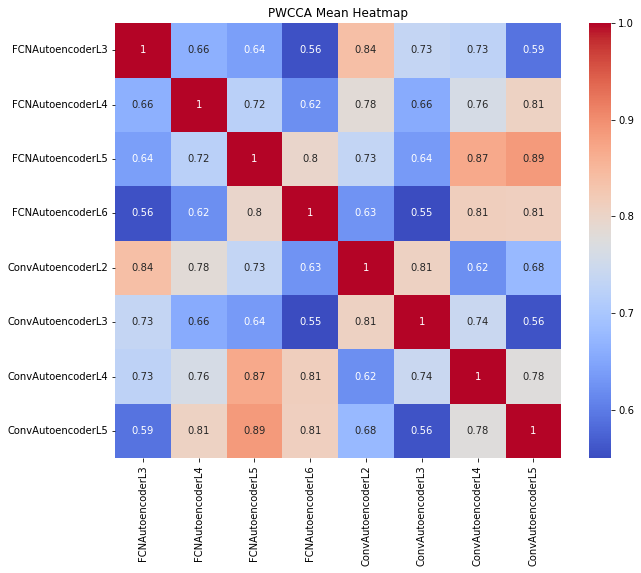

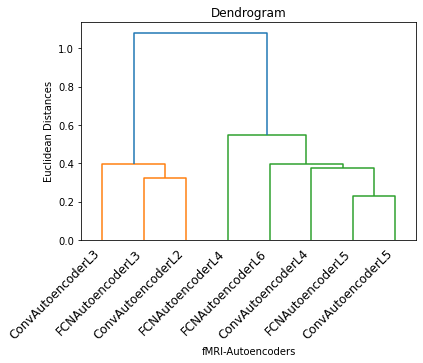

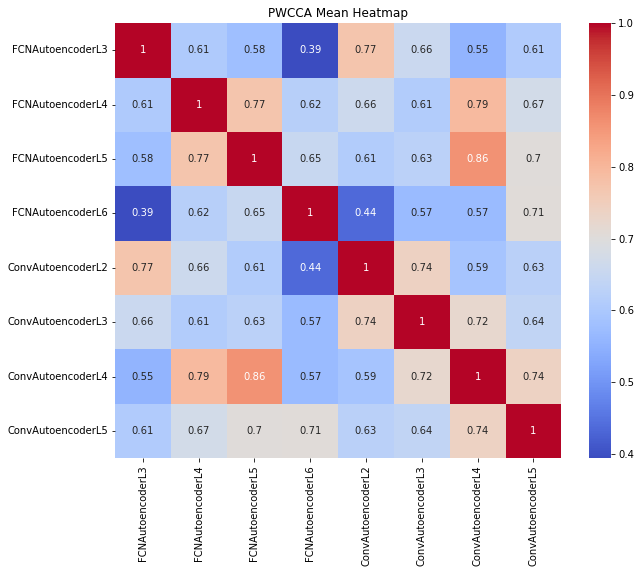

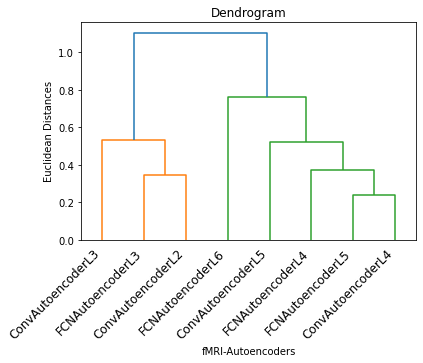

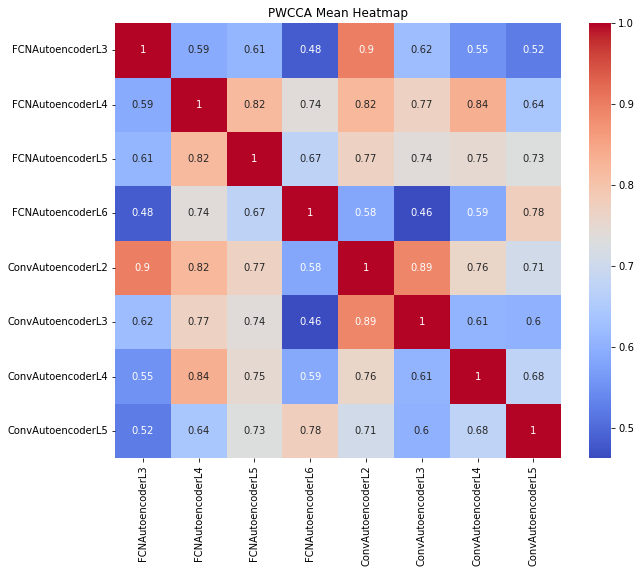

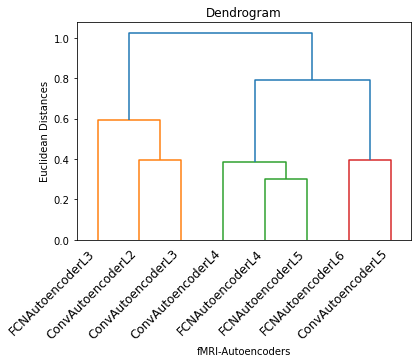

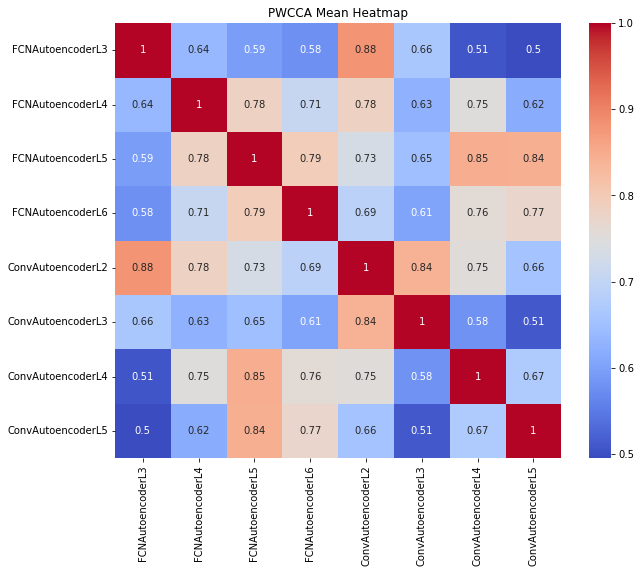

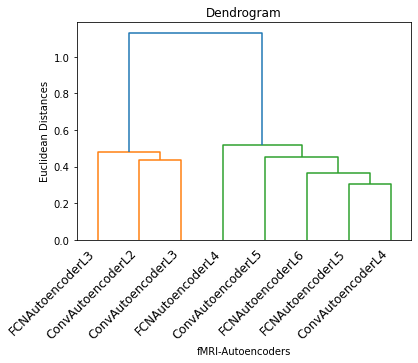

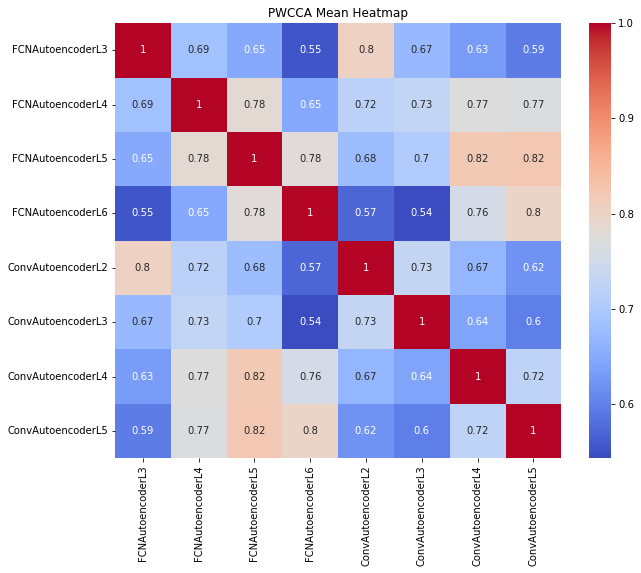

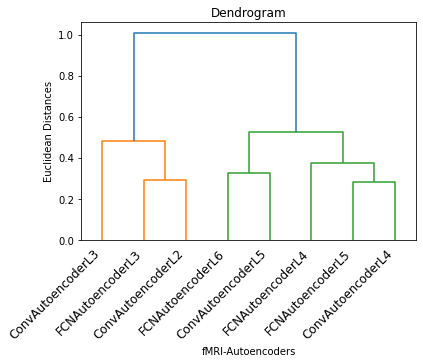

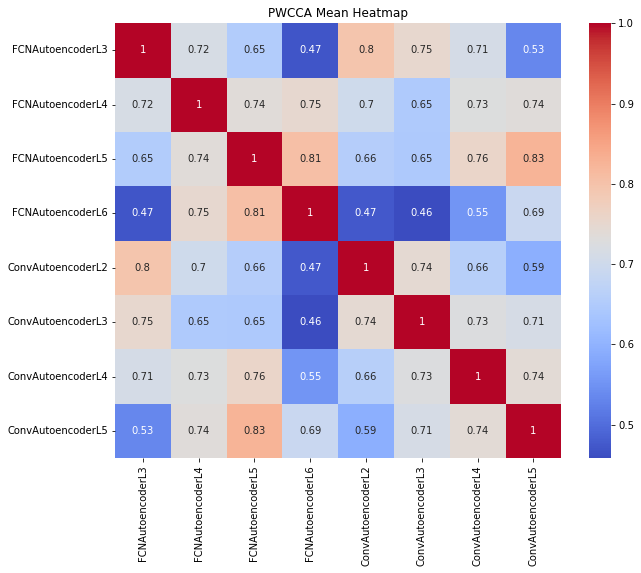

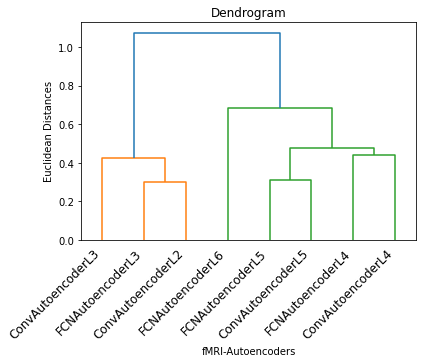

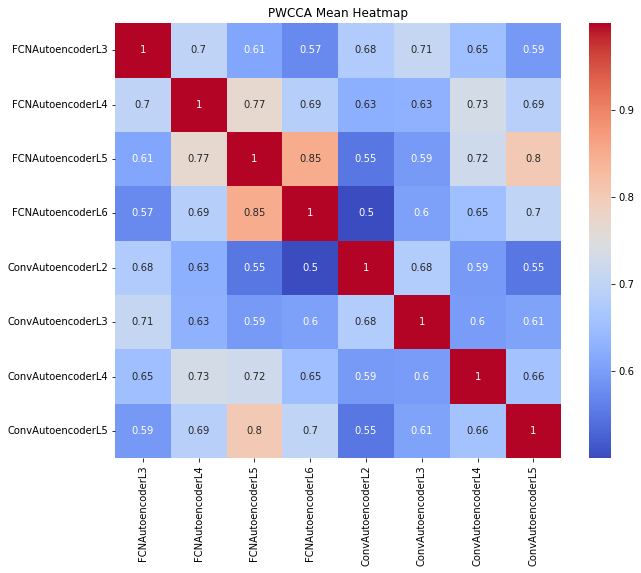

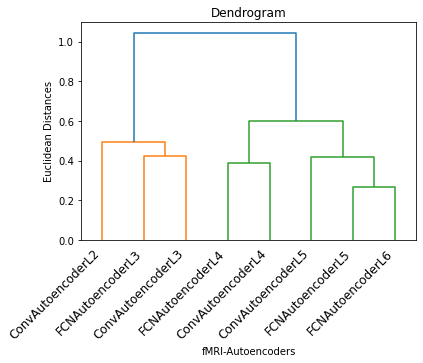

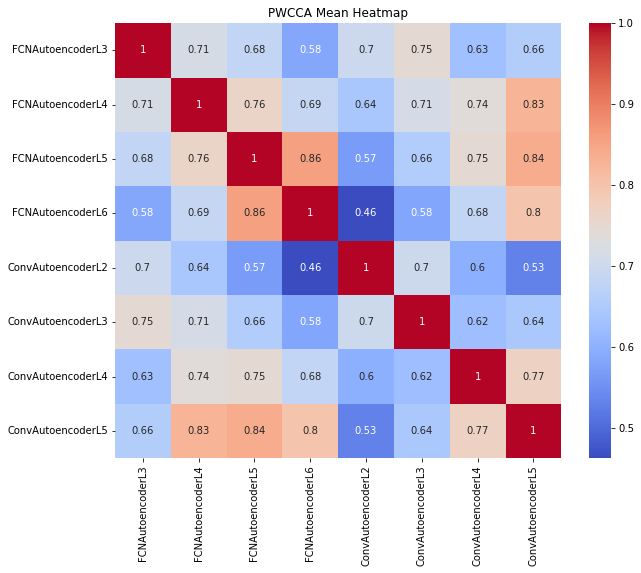

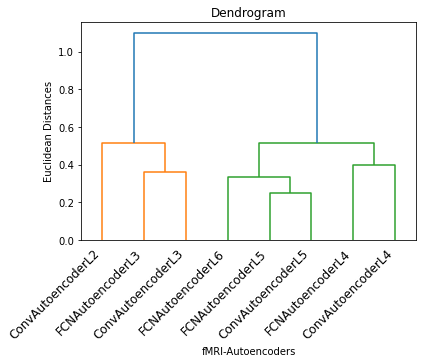

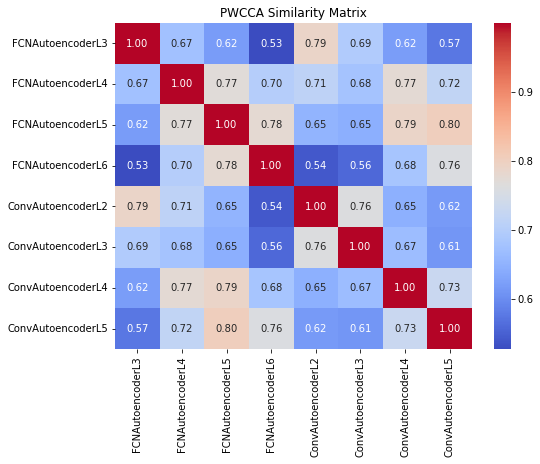

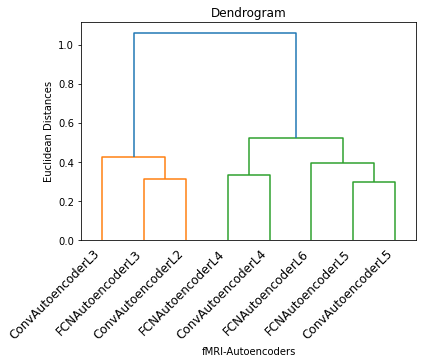

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pwcca
import scipy.cluster.hierarchy as sch

# Model names
models = ['FCNAutoencoderL3', 'FCNAutoencoderL4', 'FCNAutoencoderL5', 'FCNAutoencoderL6', 
          'ConvAutoencoderL2', 'ConvAutoencoderL3','ConvAutoencoderL4','ConvAutoencoderL5']

pwcca_matrices = []
for sim in range(1,11):
# Load the bottleneck embeddings
    embeddings = {}
    for model_name in models:
        embeddings[model_name] = torch.load(f'temp/sim/{model_name}_sim_{sim}_bottlenecks_train.pt')

    # Initialize the PWCCA mean matrix
    pwcca_matrix = torch.zeros(len(models), len(models))

    # Calculate PWCCA for each pair of models
    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            try:
                acts1 = torch.cat(embeddings[model1], dim=0).numpy().squeeze().T
                acts2 = torch.cat(embeddings[model2], dim=0).numpy().squeeze().T
                pwcca_mean, _, _ = pwcca.compute_pwcca(acts1, acts2, epsilon=1e-10)
                pwcca_matrix[i, j] = pwcca_mean
                #print(model1,model2,acts1.shape, acts2.shape)
            except IndexError:
                # If there's an error, leave the cell as NaN
                #print(model1,model2, 'Error',acts1.shape, acts2.shape)
                continue

    pwcca_matrices.append(pwcca_matrix)
    
    # Plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pwcca_matrix, annot=True, xticklabels=models, yticklabels=models, cmap='coolwarm')
    plt.title("PWCCA Mean Heatmap")
    plt.savefig('plt/sim/PWCCA_Mean_Heatmap_sim_{sim}')
    plt.show()
    
    distance_matrix = 1 - pwcca_matrix
    dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)
    plt.title('Dendrogram')
    plt.xlabel('fMRI-Autoencoders')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Euclidean Distances')
    plt.savefig('plt/sim/PWCCA_Dendrogram_Clusters_sim_{sim}')
    plt.show()
                
average_pwcca = torch.mean(torch.stack(pwcca_matrices), dim=0).float()
pwcca_df = pd.DataFrame(average_pwcca)
pwcca_df.to_excel('dfs/pwcca_matrix_avg.xlsx')
                
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(average_pwcca, annot=True, xticklabels=models, yticklabels=models, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('PWCCA Similarity Matrix')
plt.savefig('plt/results/PWCCA_Mean_Heatmap_allSims', bbox_inches='tight')
plt.show()

distance_matrix = 1 - average_pwcca
dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)
plt.title('Dendrogram')
plt.xlabel('fMRI-Autoencoders')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Euclidean Distances')
plt.savefig('plt/results/PWCCA_Dendrogram_Clusters_allSims', bbox_inches='tight')
plt.show()

#### RSA

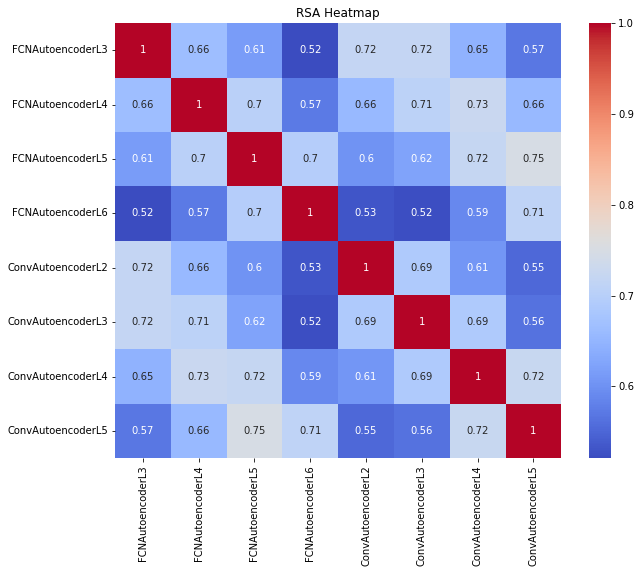

/tmp/ipykernel_46340/1151265812.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)


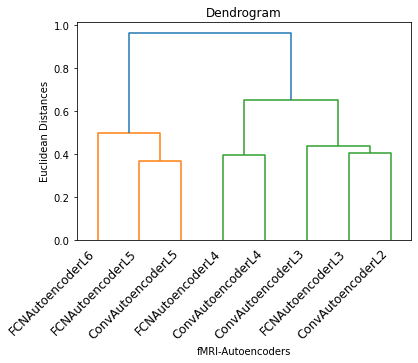

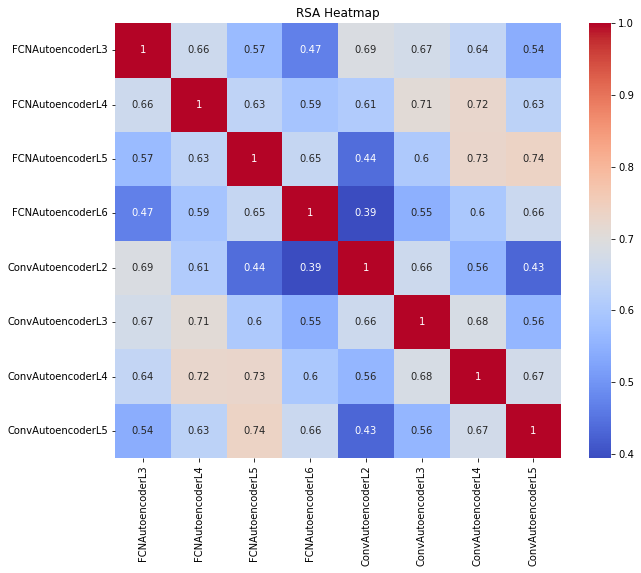

/tmp/ipykernel_46340/1151265812.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)


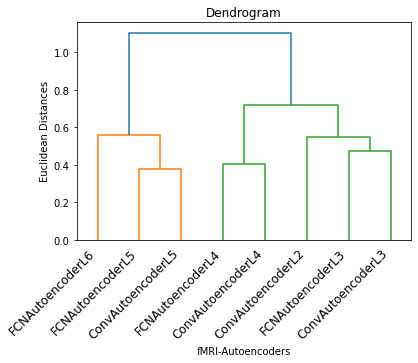

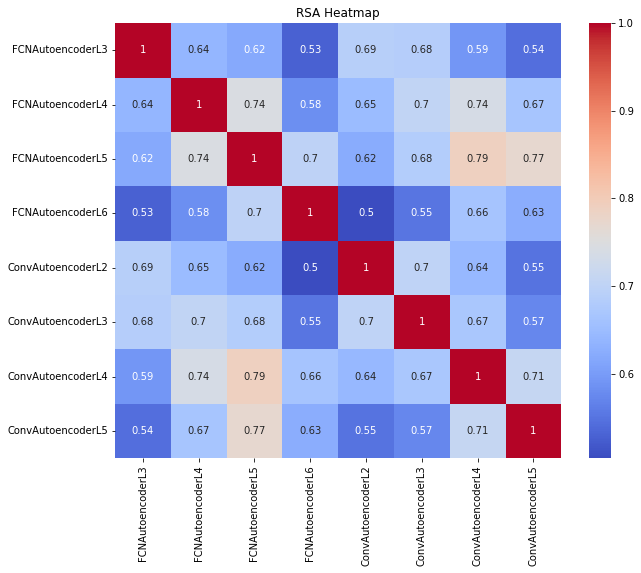

/tmp/ipykernel_46340/1151265812.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)


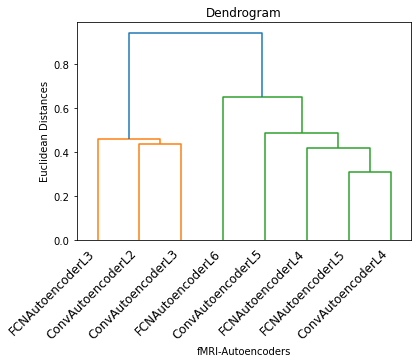

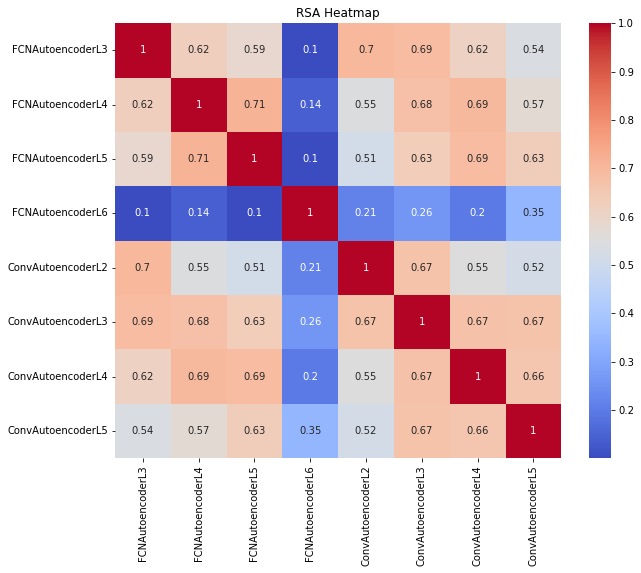

/tmp/ipykernel_46340/1151265812.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)


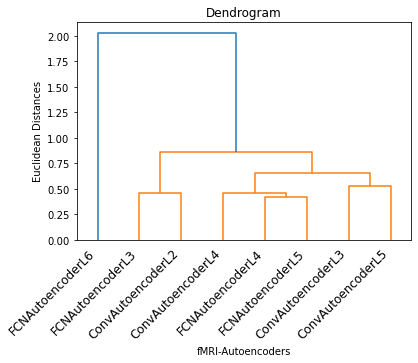

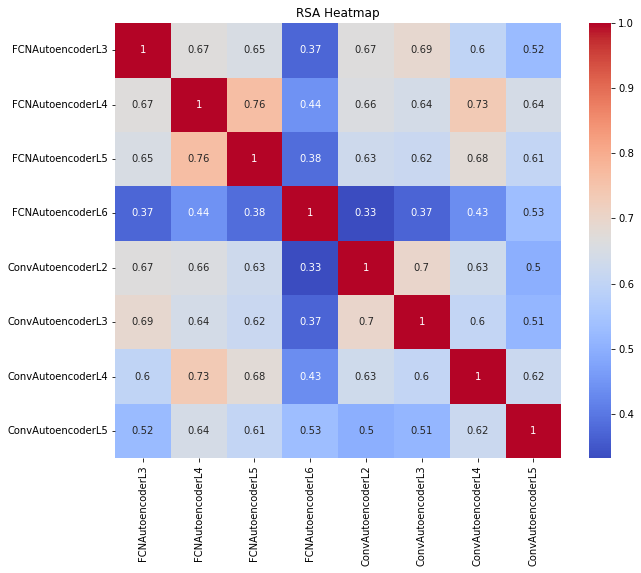

/tmp/ipykernel_46340/1151265812.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)


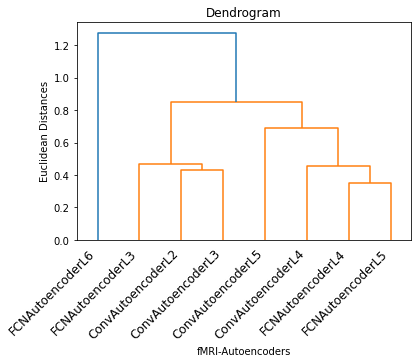

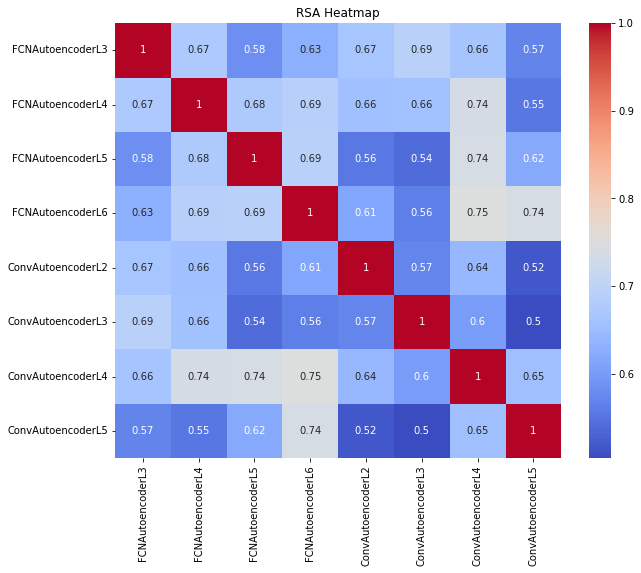

/tmp/ipykernel_46340/1151265812.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)


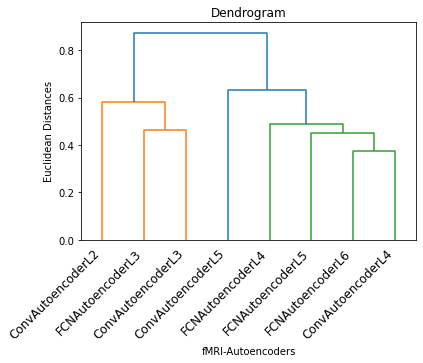

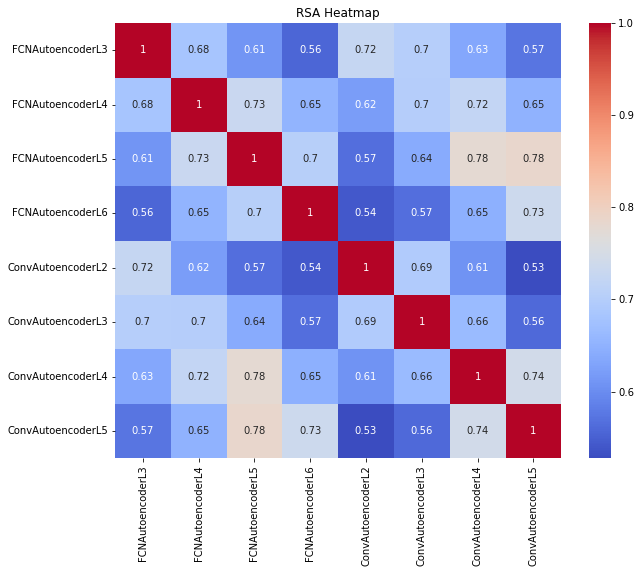

/tmp/ipykernel_46340/1151265812.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)


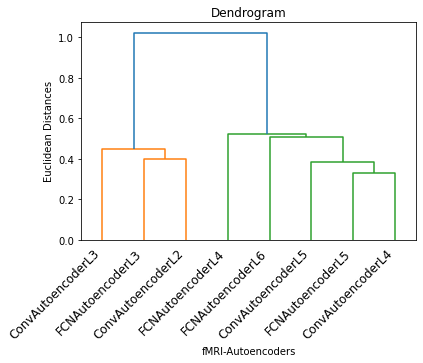

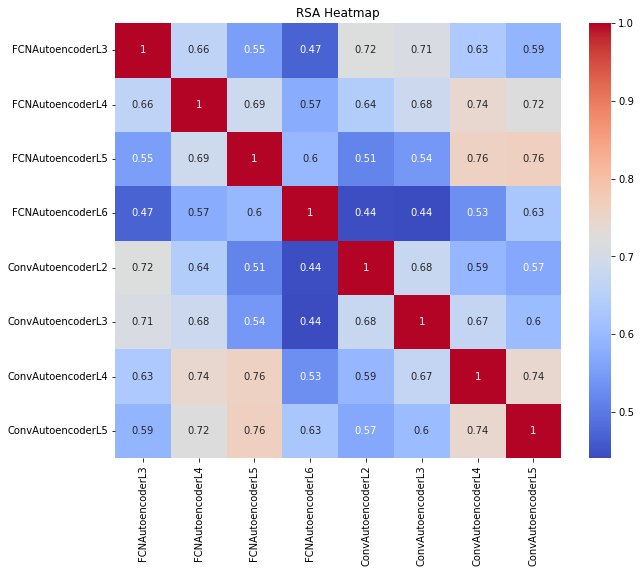

/tmp/ipykernel_46340/1151265812.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)


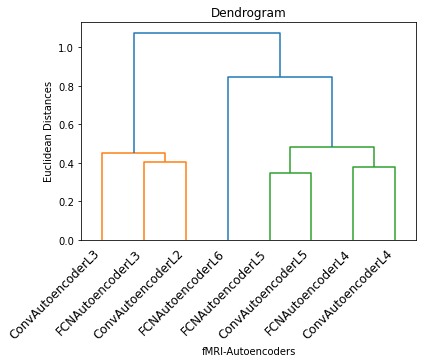

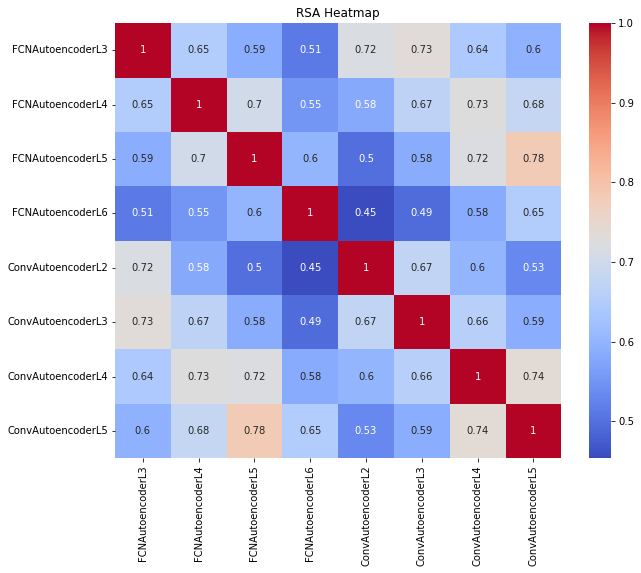

/tmp/ipykernel_46340/1151265812.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)


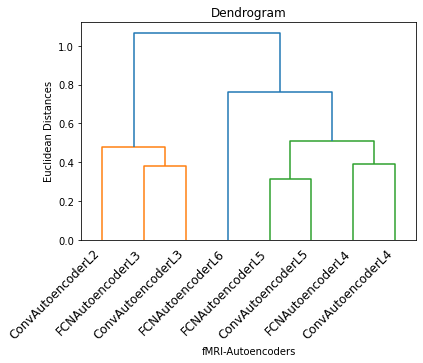

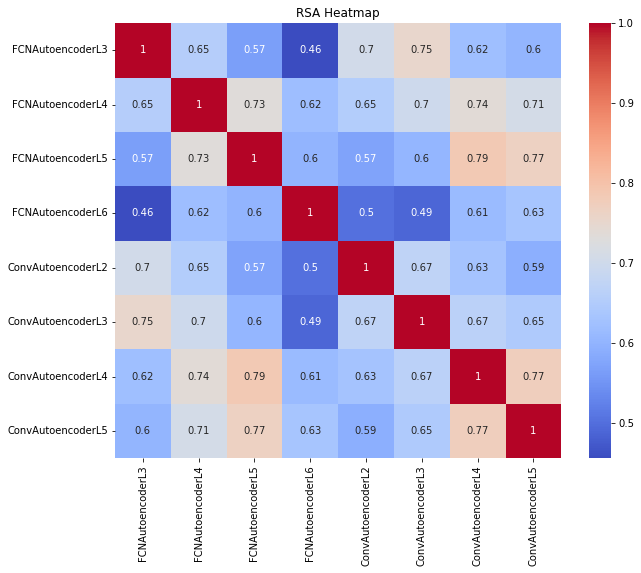

/tmp/ipykernel_46340/1151265812.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)


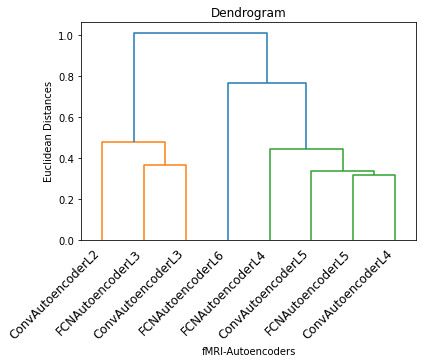

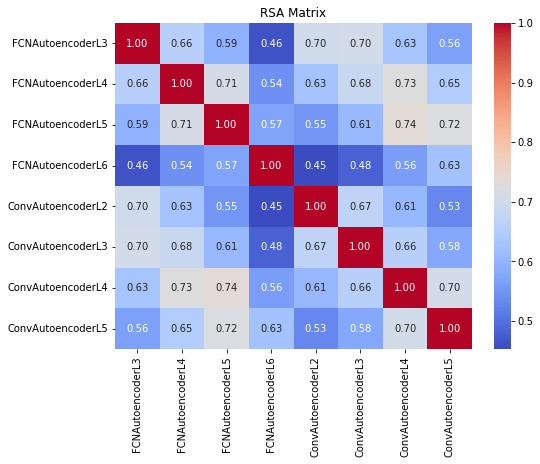

/tmp/ipykernel_46340/1151265812.py:63: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)


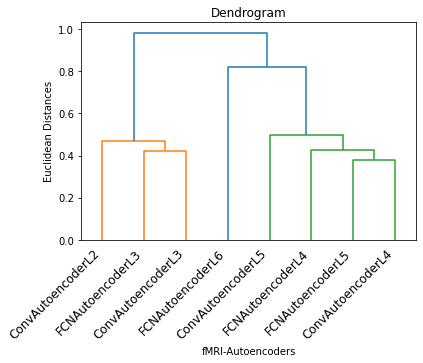

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pwcca
from rsa_similarity import rsa_similarity

# Model names
models = ['FCNAutoencoderL3', 'FCNAutoencoderL4', 'FCNAutoencoderL5', 'FCNAutoencoderL6', 
          'ConvAutoencoderL2', 'ConvAutoencoderL3','ConvAutoencoderL4','ConvAutoencoderL5']

rsa_matrices = []
for sim in range(1,11):
    embeddings = {}
    for model_name in models:
        embeddings[model_name] = torch.load(f'temp/sim/{model_name}_sim_{sim}_bottlenecks_train.pt')

# Initialize the PWCCA mean matrix
    rsa_matrix = torch.zeros(len(models), len(models))

# Calculate PWCCA for each pair of models
    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            try:
                acts1 = torch.cat(embeddings[model1], dim=0).numpy().squeeze()
                acts2 = torch.cat(embeddings[model2], dim=0).numpy().squeeze()
                rsa_sim = rsa_similarity(acts1, acts2, sample_size = 8544)
                rsa_matrix[i, j] = rsa_sim
            #print(model1,model2,acts1.shape, acts2.shape)
            except IndexError:
                # If there's an error, leave the cell as NaN
                print(model1,model2, 'Error',acts1.shape, acts2.shape)
                continue

    rsa_matrices.append(rsa_matrix)
    
    # Plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(rsa_matrix, annot=True, xticklabels=models, yticklabels=models, cmap='coolwarm')
    plt.title("RSA Heatmap")
    plt.savefig('plt/sim/RSA_Heatmap_sim_{sim}')
    plt.show()
    
    distance_matrix = 1 - rsa_matrix
    dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)
    plt.title('Dendrogram')
    plt.xlabel('fMRI-Autoencoders')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Euclidean Distances')
    plt.savefig('plt/sim/RSA_Dendrogram_Clusters_sim_{sim}')
    plt.show()
                
average_rsa = torch.mean(torch.stack(rsa_matrices), dim=0).float()
rsa_df = pd.DataFrame(average_rsa)
rsa_df.to_excel('dfs/rsa_matrix_avg.xlsx')
                
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(average_rsa, annot=True, xticklabels=models, yticklabels=models, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('RSA Matrix')
plt.savefig('plt/results/RSA_Mean_Heatmap_allSims', bbox_inches='tight')
plt.show()

distance_matrix = 1 - average_rsa
dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)
plt.title('Dendrogram')
plt.xlabel('fMRI-Autoencoders')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Euclidean Distances')
plt.savefig('plt/results/RSA_Dendrogram_Clusters_allSims', bbox_inches='tight')
plt.show()

#### CCA

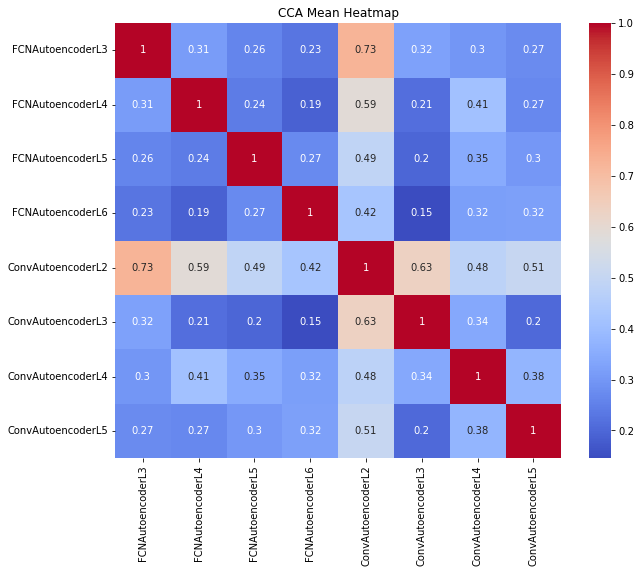

/tmp/ipykernel_46340/277146494.py:46: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)


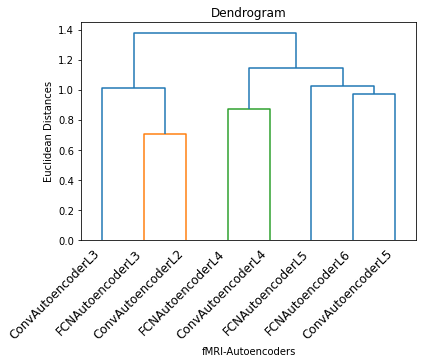

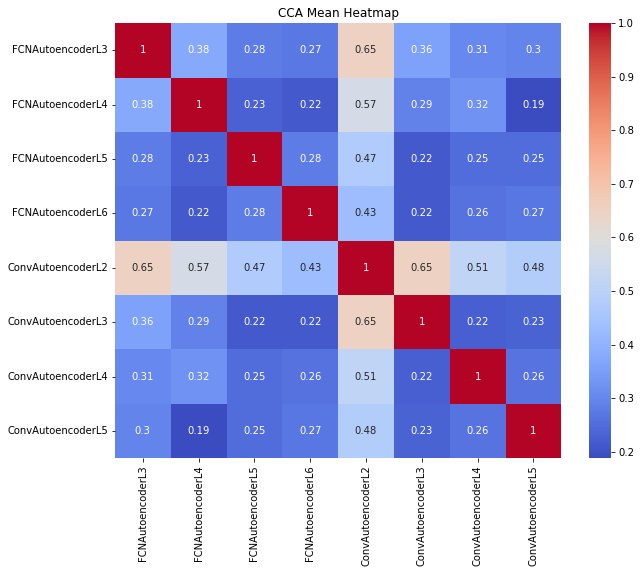

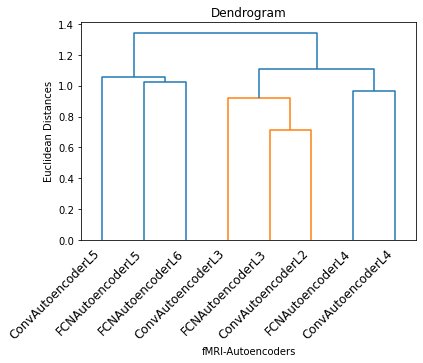

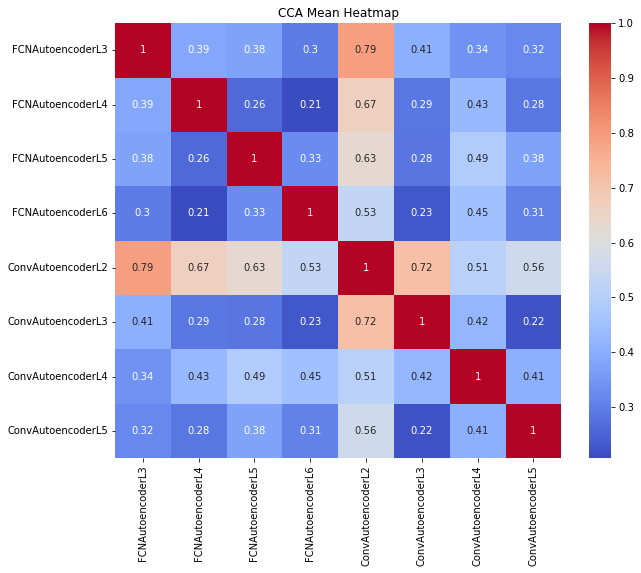

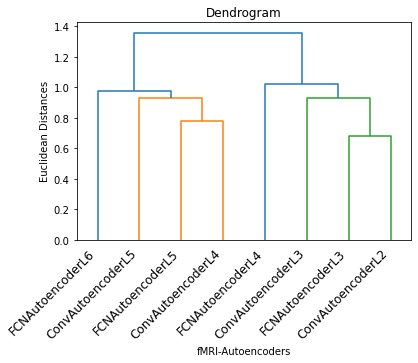

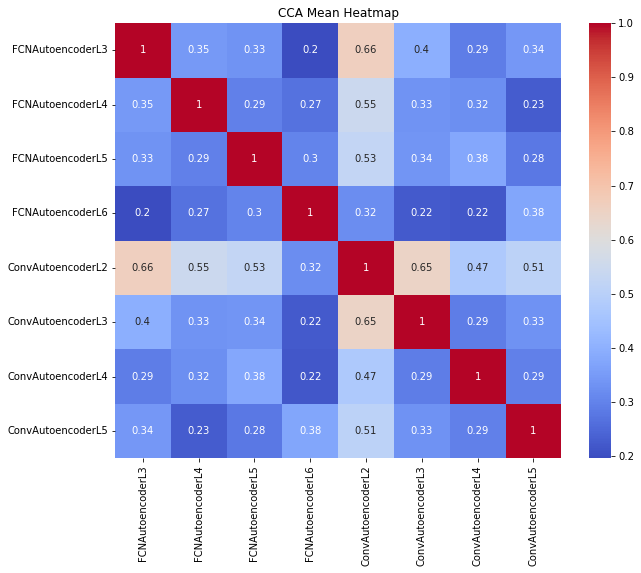

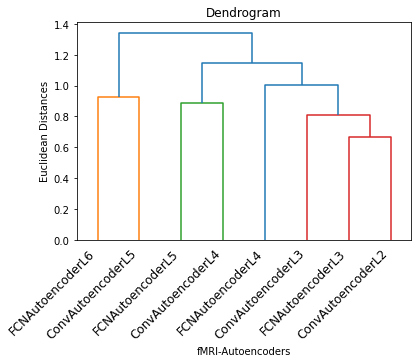

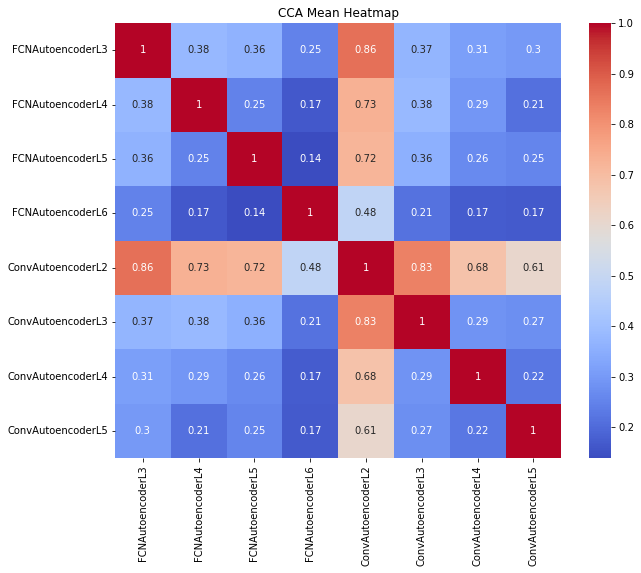

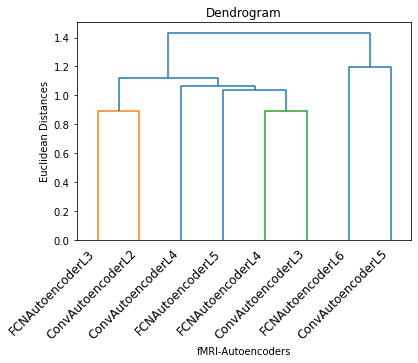

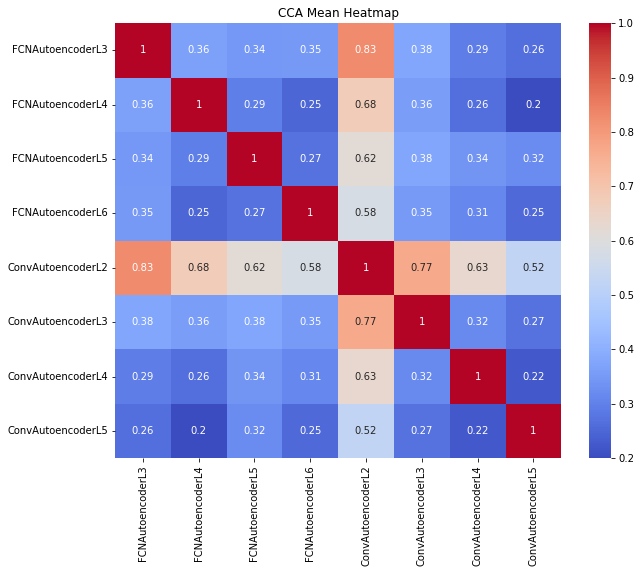

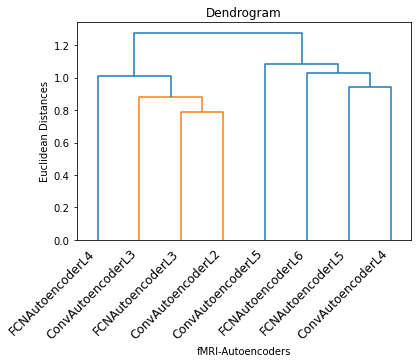

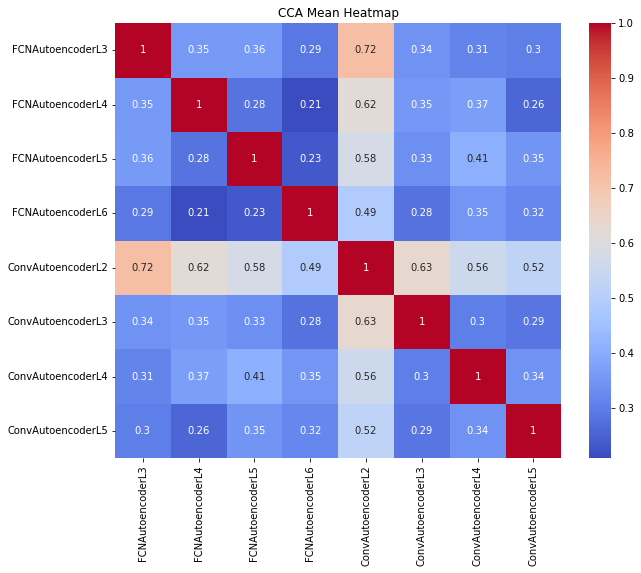

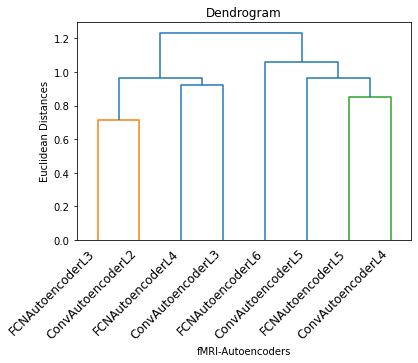

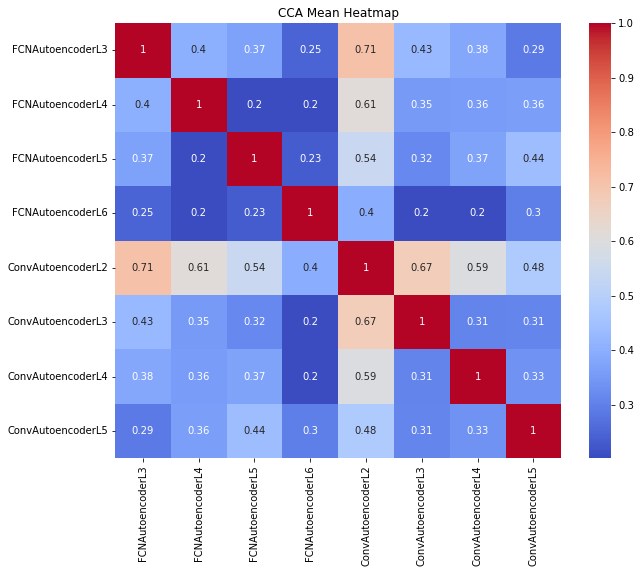

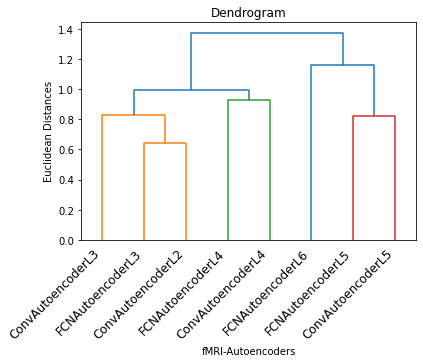

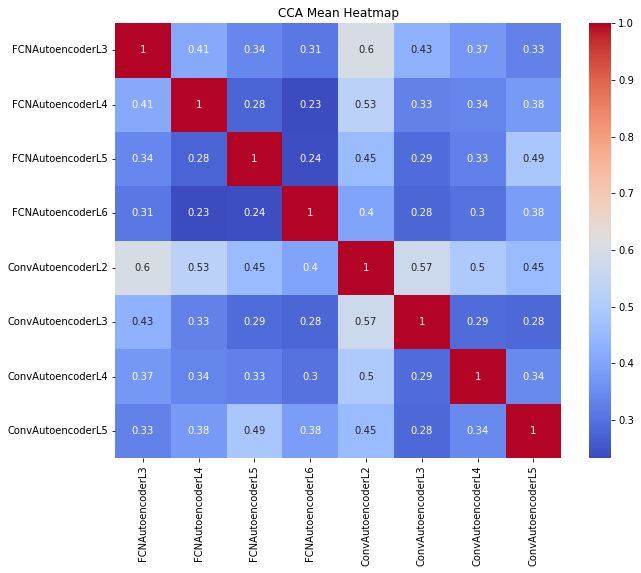

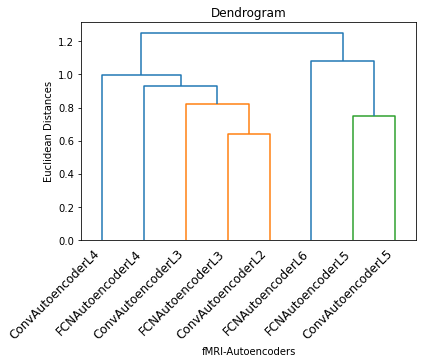

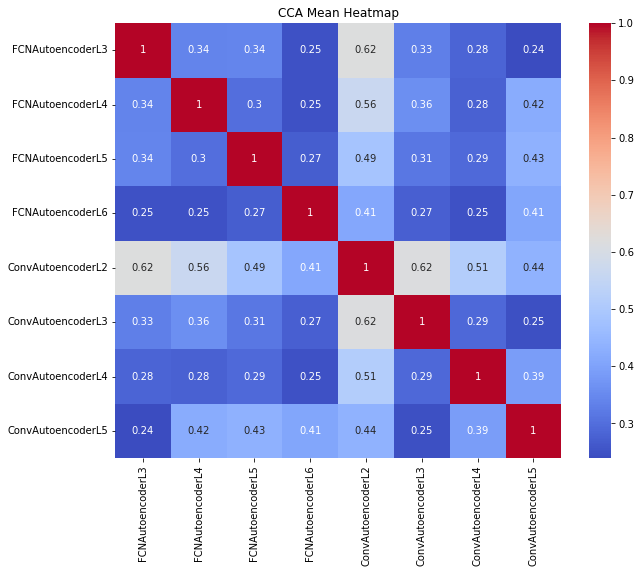

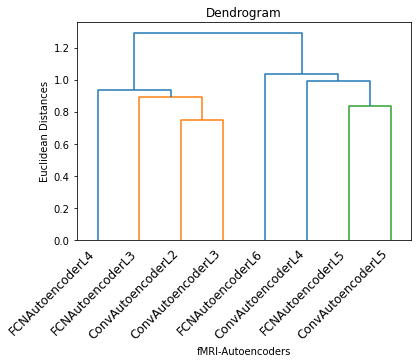

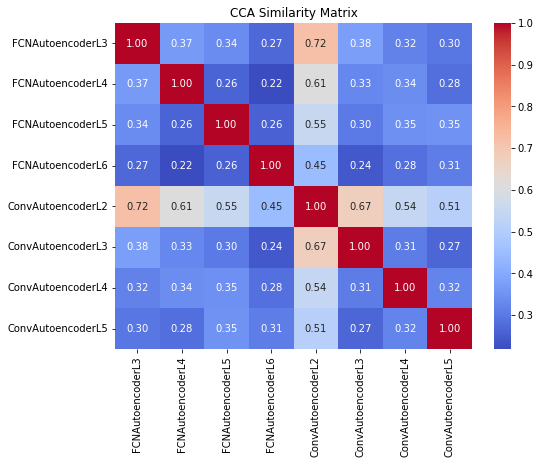

/tmp/ipykernel_46340/277146494.py:66: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)


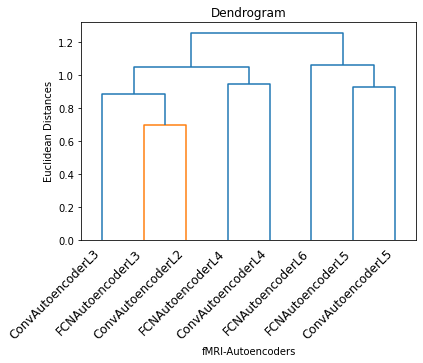

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import cca_core

# Model names
models = ['FCNAutoencoderL3', 'FCNAutoencoderL4', 'FCNAutoencoderL5', 'FCNAutoencoderL6', 
          'ConvAutoencoderL2', 'ConvAutoencoderL3','ConvAutoencoderL4','ConvAutoencoderL5']

cca_matrices = []
for sim in range(1,11):
# Load the bottleneck embeddings
    embeddings = {}
    for model_name in models:
        embeddings[model_name] = torch.load(f'temp/sim/{model_name}_sim_{sim}_bottlenecks_train.pt')

    # Initialize the CCA mean matrix
    cca_matrix = torch.zeros(len(models), len(models))

    # Calculate CCA for each pair of models
    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            try:
                acts1 = torch.cat(embeddings[model1], dim=0).numpy().squeeze().T
                acts2 = torch.cat(embeddings[model2], dim=0).numpy().squeeze().T
                cca_mean = np.mean(cca_core.get_cca_similarity(acts1, acts2, epsilon=1e-10, verbose=False)["cca_coef1"])
                if i == j:
                    cca_mean = 1
                cca_matrix[i, j] = cca_mean
                #print(model1,model2,acts1.shape, acts2.shape)
            except IndexError:
                # If there's an error, leave the cell as NaN
                #print(model1,model2, 'Error',acts1.shape, acts2.shape)
                continue

    cca_matrices.append(cca_matrix)
    
    # Plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cca_matrix, annot=True, xticklabels=models, yticklabels=models, cmap='coolwarm')
    plt.title("CCA Mean Heatmap")
    plt.savefig('plt/sim/CCA_Mean_Heatmap_sim_{sim}')
    plt.show()
    
    distance_matrix = 1 - cca_matrix
    dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)
    plt.title('Dendrogram')
    plt.xlabel('fMRI-Autoencoders')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Euclidean Distances')
    plt.savefig('plt/sim/CCA_Dendrogram_Clusters_sim_{sim}')
    plt.show()
                
average_cca = torch.mean(torch.stack(cca_matrices), dim=0).float()
cca_df = pd.DataFrame(average_cca)
cca_df.to_excel('dfs/cca_matrix_avg.xlsx')
                
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(average_cca, annot=True, xticklabels=models, yticklabels=models, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('CCA Similarity Matrix')
plt.savefig('plt/results/CCA_Mean_Heatmap_allSims', bbox_inches='tight')
plt.show()

distance_matrix = 1 - average_cca
dendrogram = sch.dendrogram(sch.linkage(distance_matrix, method='ward'), labels=models)
plt.title('Dendrogram')
plt.xlabel('fMRI-Autoencoders')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Euclidean Distances')
plt.savefig('plt/results/CCA_Dendrogram_Clusters_allSims', bbox_inches='tight')
plt.show()

### Caption Embedding

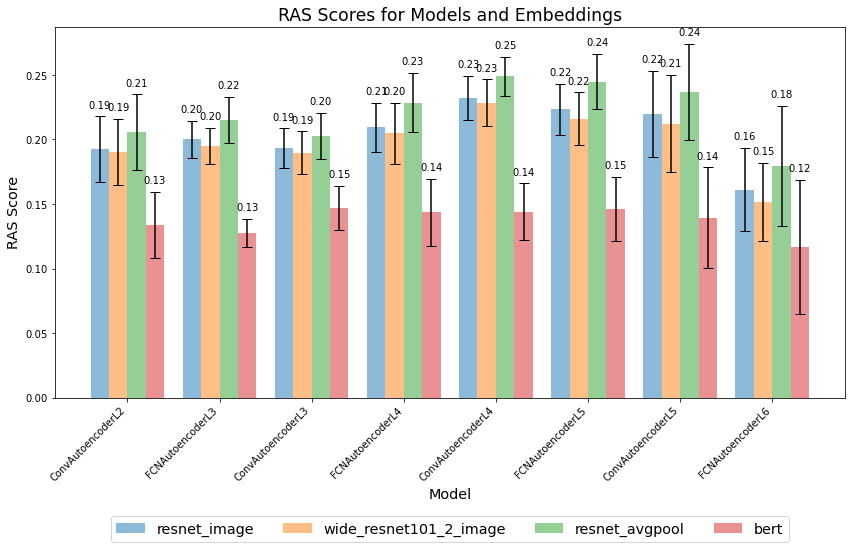

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pwcca
import torch
from rsa_similarity import rsa_similarity
import pandas as pd

# Model names for fMRI embeddings
fmri_models = ['ConvAutoencoderL2', 'FCNAutoencoderL3', 'ConvAutoencoderL3',
               'FCNAutoencoderL4', 'ConvAutoencoderL4',
               'FCNAutoencoderL5','ConvAutoencoderL5', 'FCNAutoencoderL6']

# List of image embeddings to compare with
image_embeddings_files = ['embeddings/resnet_image_embeddings_train.pt',
                          'embeddings/resnet_avgpool_embeddings_train.pt',
                         'embeddings/bert_embeddings_train.pt',
                         'embeddings/wide_resnet101_2_image_embeddings_train.pt']

# image_embeddings_files = [
#     f'embeddings/{model_name}_image_embeddings_train.pt' for model_name, _ in model_names
# ]

pwcca_dfs = []
for sim in range(1,11):
    # Initialize the PWCCA score matrices for each pair of embeddings
    pwcca_scores = {fmri_model: {image_file[11:-20]: None for image_file in image_embeddings_files} for fmri_model in fmri_models}

    # Load the fMRI embeddings
    fmri_embeddings = {}
    for fmri_model in fmri_models:
        fmri_embeddings[fmri_model] = torch.load(f'temp/sim/{fmri_model}_sim_{sim}_bottlenecks_train.pt')
        
    # Calculate PWCCA scores for each fMRI embedding and each image embedding
    for fmri_model in fmri_models:
        for image_file in image_embeddings_files:
            image_embeddings = torch.load(image_file)
        
            acts1 = torch.cat(fmri_embeddings[fmri_model], dim=0).numpy().squeeze()
            acts2 = image_embeddings
            pwcca_mean = rsa_similarity(acts1, acts2, 8544)
            pwcca_scores[fmri_model][image_file[11:-20]] = pwcca_mean

    pwcca_df = pd.DataFrame(pwcca_scores).T
    pwcca_df = pwcca_df.reset_index()
    pwcca_dfs.append(pwcca_df)
    pwcca_avg = pd.concat(pwcca_dfs).groupby(level=0).mean()
    pwcca_std = pd.concat(pwcca_dfs).groupby(level=0).std()
    
    pwcca_avg['index'] = fmri_models
    pwcca_avg = pwcca_avg[['index', 'resnet_image', 'wide_resnet101_2_image', 'resnet_avgpool','bert']]
    pwcca_std['index'] = fmri_models
    pwcca_std = pwcca_std[['index', 'resnet_image', 'wide_resnet101_2_image', 'resnet_avgpool', 'bert']]
    
pwcca_avg.to_excel('dfs/RAS_Model_Embedding_avg.xlsx')
pwcca_std.to_excel('dfs/RAS_Model_Embedding_std.xlsx')

plt.figure(figsize=(12, 8))
x_indices = np.arange(len(pwcca_avg['index']))
bar_width = 0.2

for i, column in enumerate(pwcca_avg.columns[1:]):
    plt.bar(x_indices + i * bar_width, pwcca_avg[column], width=bar_width, alpha=0.5, label=f'{column}', yerr=pwcca_std[column], capsize=5)
    # yerr=pwcca_std[column] adds the std bars to the plot
    # We use capsize to add caps to the error bars

plt.xlabel('Model', fontsize='x-large')
plt.ylabel('RAS Score', fontsize='x-large')
plt.title('RAS Scores for Models and Embeddings', fontsize='xx-large')
plt.xticks(x_indices + (len(pwcca_avg.columns[1:]) - 1) * bar_width / 2, pwcca_avg['index'], rotation=45, ha='right')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=4, fontsize='x-large')
plt.tight_layout()

# Adding average values to the graph as text
for i, column in enumerate(pwcca_avg.columns[1:]):
    for j, value in enumerate(pwcca_avg[column]):
        plt.text(x_indices[j] + i * bar_width, value+pwcca_std[column][j]+0.005, f'{value:.2f}', ha='center', va='bottom')

plt.savefig('plt/results/RAS_Model_Embeddings')
plt.show()

ConvAutoencoderL2 resnet_image (256, 8544) (1000, 8544)
ConvAutoencoderL2 resnet_avgpool (256, 8544) (2048, 8544)
ConvAutoencoderL2 bert (256, 8544) (768, 8544)
ConvAutoencoderL2 wide_resnet101_2_image (256, 8544) (1000, 8544)
FCNAutoencoderL3 resnet_image (256, 8544) (1000, 8544)
FCNAutoencoderL3 resnet_avgpool (256, 8544) (2048, 8544)
FCNAutoencoderL3 bert (256, 8544) (768, 8544)
FCNAutoencoderL3 wide_resnet101_2_image (256, 8544) (1000, 8544)
ConvAutoencoderL3 resnet_image (256, 8544) (1000, 8544)
ConvAutoencoderL3 resnet_avgpool (256, 8544) (2048, 8544)
ConvAutoencoderL3 bert (256, 8544) (768, 8544)
ConvAutoencoderL3 wide_resnet101_2_image (256, 8544) (1000, 8544)
FCNAutoencoderL4 resnet_image (256, 8544) (1000, 8544)
FCNAutoencoderL4 resnet_avgpool (256, 8544) (2048, 8544)
FCNAutoencoderL4 bert (256, 8544) (768, 8544)
FCNAutoencoderL4 wide_resnet101_2_image (256, 8544) (1000, 8544)
ConvAutoencoderL4 resnet_image (256, 8544) (1000, 8544)
ConvAutoencoderL4 resnet_avgpool (256, 8544)

ConvAutoencoderL4 bert (256, 8544) (768, 8544)
ConvAutoencoderL4 wide_resnet101_2_image (256, 8544) (1000, 8544)
FCNAutoencoderL5 resnet_image (256, 8544) (1000, 8544)
FCNAutoencoderL5 resnet_avgpool (256, 8544) (2048, 8544)
FCNAutoencoderL5 bert (256, 8544) (768, 8544)
FCNAutoencoderL5 wide_resnet101_2_image (256, 8544) (1000, 8544)
ConvAutoencoderL5 resnet_image (256, 8544) (1000, 8544)
ConvAutoencoderL5 resnet_avgpool (256, 8544) (2048, 8544)
ConvAutoencoderL5 bert (256, 8544) (768, 8544)
ConvAutoencoderL5 wide_resnet101_2_image (256, 8544) (1000, 8544)
FCNAutoencoderL6 resnet_image (256, 8544) (1000, 8544)
FCNAutoencoderL6 resnet_avgpool (256, 8544) (2048, 8544)
FCNAutoencoderL6 bert (256, 8544) (768, 8544)
FCNAutoencoderL6 wide_resnet101_2_image (256, 8544) (1000, 8544)
ConvAutoencoderL2 resnet_image (256, 8544) (1000, 8544)
ConvAutoencoderL2 resnet_avgpool (256, 8544) (2048, 8544)
ConvAutoencoderL2 bert (256, 8544) (768, 8544)
ConvAutoencoderL2 wide_resnet101_2_image (256, 8544) 

FCNAutoencoderL3 resnet_image (256, 8544) (1000, 8544)
FCNAutoencoderL3 resnet_avgpool (256, 8544) (2048, 8544)
FCNAutoencoderL3 bert (256, 8544) (768, 8544)
FCNAutoencoderL3 wide_resnet101_2_image (256, 8544) (1000, 8544)
ConvAutoencoderL3 resnet_image (256, 8544) (1000, 8544)
ConvAutoencoderL3 resnet_avgpool (256, 8544) (2048, 8544)
ConvAutoencoderL3 bert (256, 8544) (768, 8544)
ConvAutoencoderL3 wide_resnet101_2_image (256, 8544) (1000, 8544)
FCNAutoencoderL4 resnet_image (256, 8544) (1000, 8544)
FCNAutoencoderL4 resnet_avgpool (256, 8544) (2048, 8544)
FCNAutoencoderL4 bert (256, 8544) (768, 8544)
FCNAutoencoderL4 wide_resnet101_2_image (256, 8544) (1000, 8544)
ConvAutoencoderL4 resnet_image (256, 8544) (1000, 8544)
ConvAutoencoderL4 resnet_avgpool (256, 8544) (2048, 8544)
ConvAutoencoderL4 bert (256, 8544) (768, 8544)
ConvAutoencoderL4 wide_resnet101_2_image (256, 8544) (1000, 8544)
FCNAutoencoderL5 resnet_image (256, 8544) (1000, 8544)
FCNAutoencoderL5 resnet_avgpool (256, 8544) (

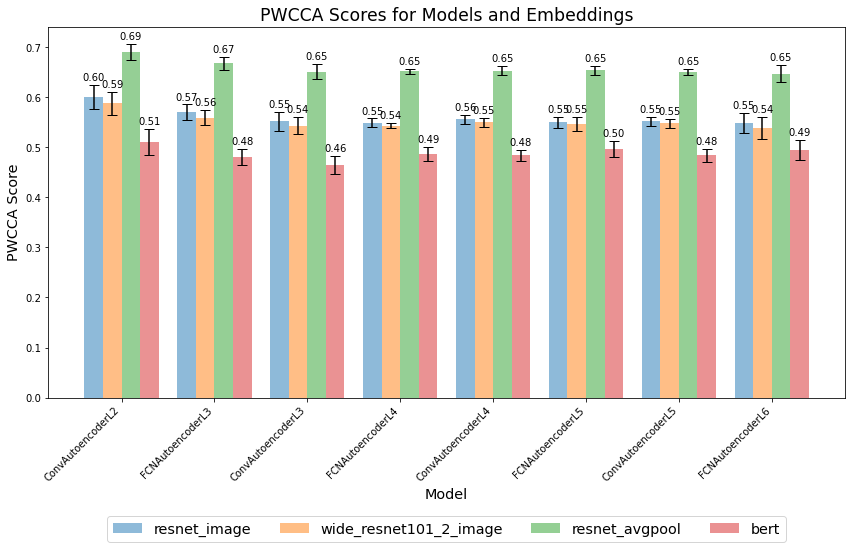

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pwcca
import torch
from rsa_similarity import rsa_similarity
import pandas as pd

# Model names for fMRI embeddings
fmri_models = ['ConvAutoencoderL2', 'FCNAutoencoderL3', 'ConvAutoencoderL3',
               'FCNAutoencoderL4', 'ConvAutoencoderL4',
               'FCNAutoencoderL5','ConvAutoencoderL5', 'FCNAutoencoderL6']

# List of image embeddings to compare with
image_embeddings_files = ['embeddings/resnet_image_embeddings_train.pt',
                          'embeddings/resnet_avgpool_embeddings_train.pt',
                         'embeddings/bert_embeddings_train.pt',
                         'embeddings/wide_resnet101_2_image_embeddings_train.pt']

# image_embeddings_files = [
#     f'embeddings/{model_name}_image_embeddings_train.pt' for model_name, _ in model_names
# ]

pwcca_dfs = []
for sim in range(1,11):
    # Initialize the PWCCA score matrices for each pair of embeddings
    pwcca_scores = {fmri_model: {image_file[11:-20]: None for image_file in image_embeddings_files} for fmri_model in fmri_models}

    # Load the fMRI embeddings
    fmri_embeddings = {}
    for fmri_model in fmri_models:
        fmri_embeddings[fmri_model] = torch.load(f'temp/sim/{fmri_model}_sim_{sim}_bottlenecks_train.pt')

    # Calculate PWCCA scores for each fMRI embedding and each image embedding
    for fmri_model in fmri_models:
        for image_file in image_embeddings_files:
            image_embeddings = torch.load(image_file)
        
            acts1 = torch.cat(fmri_embeddings[fmri_model], dim=0).numpy().squeeze().T
            if 'pool' in image_file:
                image_embeddings = image_embeddings.numpy()
            acts2 = image_embeddings.T
            print(fmri_model,image_file[11:-20],acts1.shape, acts2.shape)
            pwcca_mean, _, _ = pwcca.compute_pwcca(acts1, acts2, epsilon=1e-10)
            
            pwcca_scores[fmri_model][image_file[11:-20]] = pwcca_mean

    pwcca_df = pd.DataFrame(pwcca_scores).T
    pwcca_df = pwcca_df.reset_index()
    pwcca_dfs.append(pwcca_df)
    pwcca_avg = pd.concat(pwcca_dfs).groupby(level=0).mean()
    pwcca_std = pd.concat(pwcca_dfs).groupby(level=0).std()
    
    pwcca_avg['index'] = fmri_models
    pwcca_avg = pwcca_avg[['index', 'resnet_image', 'wide_resnet101_2_image', 'resnet_avgpool','bert']]
    pwcca_std['index'] = fmri_models
    pwcca_std = pwcca_std[['index', 'resnet_image', 'wide_resnet101_2_image', 'resnet_avgpool','bert']]
    
pwcca_avg.to_excel('dfs/PWCCA_Model_Embedding_avg.xlsx')
pwcca_std.to_excel('dfs/PWCCA_Model_Embedding_std.xlsx')

plt.figure(figsize=(12, 8))
x_indices = np.arange(len(pwcca_avg['index']))
bar_width = 0.2

for i, column in enumerate(pwcca_avg.columns[1:]):
    plt.bar(x_indices + i * bar_width, pwcca_avg[column], width=bar_width, alpha=0.5, label=f'{column}', yerr=pwcca_std[column], capsize=5)
    # yerr=pwcca_std[column] adds the std bars to the plot
    # We use capsize to add caps to the error bars

plt.xlabel('Model', fontsize='x-large')
plt.ylabel('PWCCA Score', fontsize='x-large')
plt.title('PWCCA Scores for Models and Embeddings', fontsize='xx-large')
plt.xticks(x_indices + (len(pwcca_avg.columns[1:]) - 1) * bar_width / 2, pwcca_avg['index'], rotation=45, ha='right')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=4, fontsize='x-large')
plt.tight_layout()

# Adding average values to the graph as text
for i, column in enumerate(pwcca_avg.columns[1:]):
    for j, value in enumerate(pwcca_avg[column]):
        plt.text(x_indices[j] + i * bar_width, value+pwcca_std[column][j]+0.005, f'{value:.2f}', ha='center', va='bottom')

plt.savefig('plt/results/PWCCA_Model_Embeddings')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pwcca
import torch
from rsa_similarity import rsa_similarity
import pandas as pd

# Model names for fMRI embeddings
fmri_models = ['ConvAutoencoderL2', 'FCNAutoencoderL3', 'ConvAutoencoderL3',
               'FCNAutoencoderL4', 'ConvAutoencoderL4',
               'FCNAutoencoderL5','ConvAutoencoderL5', 'FCNAutoencoderL6']

# List of image embeddings to compare with
image_embeddings_files = ['embeddings/resnet_image_embeddings_train.pt',
                          'embeddings/resnet_avgpool_embeddings_train.pt',
                         'embeddings/bert_embeddings_train.pt']

# image_embeddings_files = [
#     f'embeddings/{model_name}_image_embeddings_train.pt' for model_name, _ in model_names
# ]

pwcca_dfs = []
for sim in range(1,11):
    # Initialize the PWCCA score matrices for each pair of embeddings
    pwcca_scores = {fmri_model: {image_file[11:-20]: None for image_file in image_embeddings_files} for fmri_model in fmri_models}

    # Load the fMRI embeddings
    fmri_embeddings = {}
    for fmri_model in fmri_models:
        fmri_embeddings[fmri_model] = torch.load(f'temp/{fmri_model}_bottlenecks_train.pt')

    # Calculate PWCCA scores for each fMRI embedding and each image embedding
    for fmri_model in fmri_models:
        for image_file in image_embeddings_files:
            image_embeddings = torch.load(image_file)
        
            acts1 = torch.cat(fmri_embeddings[fmri_model], dim=0).numpy().squeeze()
            acts2 = image_embeddings
            pwcca_mean = rsa_similarity(acts1, acts2)
            pwcca_scores[fmri_model][image_file[11:-20]] = pwcca_mean

    pwcca_df = pd.DataFrame(pwcca_scores).T
    pwcca_df = pwcca_df.reset_index()
    pwcca_dfs.append(pwcca_df)
    pwcca_avg = pd.concat(pwcca_dfs).groupby(level=0).mean()
    pwcca_std = pd.concat(pwcca_dfs).groupby(level=0).std()
    
    pwcca_avg['index'] = fmri_models
    pwcca_avg = pwcca_avg[['index', 'resnet_image', 'resnet_avgpool', 'bert']]
    pwcca_std['index'] = fmri_models
    pwcca_std = pwcca_std[['index', 'resnet_image', 'resnet_avgpool', 'bert']]
    
pwcca_avg.to_excel('dfs/RAS_Model_Embedding_avg.xlsx')
pwcca_astd.to_excel('dfs/RAS_Model_Embedding_std.xlsx')

plt.figure(figsize=(12, 8))
x_indices = np.arange(len(pwcca_avg['index']))
bar_width = 0.2

for i, column in enumerate(pwcca_avg.columns[1:]):
    plt.bar(x_indices + i * bar_width, pwcca_avg[column], width=bar_width, alpha=0.5, label=f'{column}', yerr=pwcca_std[column], capsize=5)
    # yerr=pwcca_std[column] adds the std bars to the plot
    # We use capsize to add caps to the error bars

plt.xlabel('Model')
plt.ylabel('RAS Score')
plt.title('RAS Scores for Models and Embeddings')
plt.xticks(x_indices + (len(pwcca_avg.columns[1:]) - 1) * bar_width / 2, pwcca_avg['index'], rotation=45, ha='right')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
plt.tight_layout()

# Adding average values to the graph as text
for i, column in enumerate(pwcca_avg.columns[1:]):
    for j, value in enumerate(pwcca_avg[column]):
        plt.text(x_indices[j] + i * bar_width, value+pwcca_std[column][j]+0.005, f'{value:.2f}', ha='center', va='bottom')

plt.savefig('plt/results/RAS_Model_Embeddings')
plt.show()

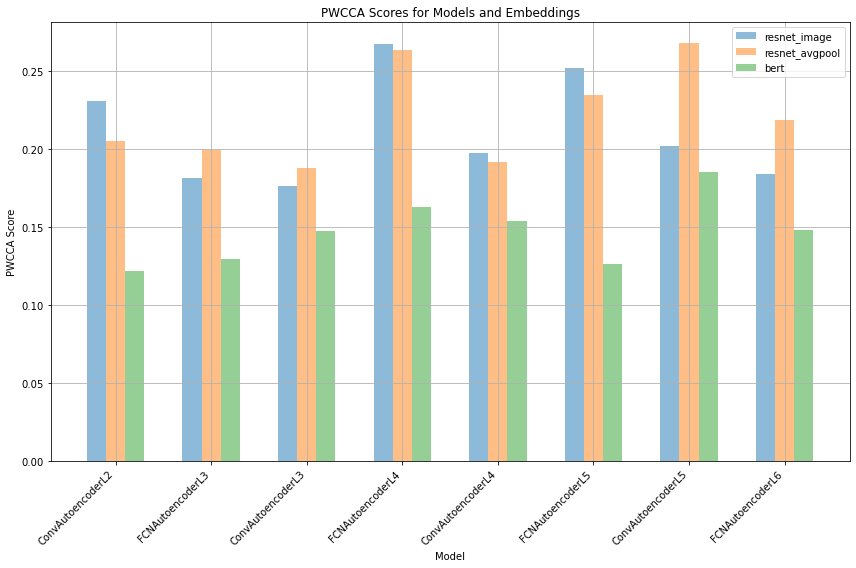

In [31]:
plt.figure(figsize=(12, 8))
x_indices = np.arange(len(pwcca_df['index']))
bar_width = 0.2

for i, column in enumerate(pwcca_df.columns[1:]):
    plt.bar(x_indices + i * bar_width, pwcca_df[column], width=bar_width, alpha=0.5, label=column)
plt.xlabel('Model')
plt.ylabel('PWCCA Score')
plt.title('PWCCA Scores for Models and Embeddings')
plt.xticks(x_indices + (len(pwcca_df.columns[1:]) - 1) * bar_width / 2, pwcca_df['index'], rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
pwcca_df

,index,resnet_image,resnet_avgpool,bert
0,ConvAutoencoderL2,0.230726,0.205108,0.122048
1,FCNAutoencoderL3,0.181181,0.199200,0.129293
2,ConvAutoencoderL3,0.176181,0.187758,0.147629
3,FCNAutoencoderL4,0.267254,0.263524,0.162796
4,ConvAutoencoderL4,0.197327,0.191558,0.154189
5,FCNAutoencoderL5,0.251783,0.234236,0.126328
6,ConvAutoencoderL5,0.201928,0.267601,0.185450
7,FCNAutoencoderL6,0.183760,0.218615,0.148405


In [36]:
pwcca_avg

,index,resnet_image,resnet_avgpool,bert
0,ConvAutoencoderL2,0.220640,0.211741,0.122828
1,FCNAutoencoderL3,0.207296,0.210436,0.125722
2,ConvAutoencoderL3,0.175630,0.188929,0.156253
3,FCNAutoencoderL4,0.249265,0.260811,0.149971
4,ConvAutoencoderL4,0.198628,0.193988,0.132864
5,FCNAutoencoderL5,0.241992,0.247978,0.134703
6,ConvAutoencoderL5,0.208038,0.258450,0.187137
7,FCNAutoencoderL6,0.180970,0.218296,0.158284


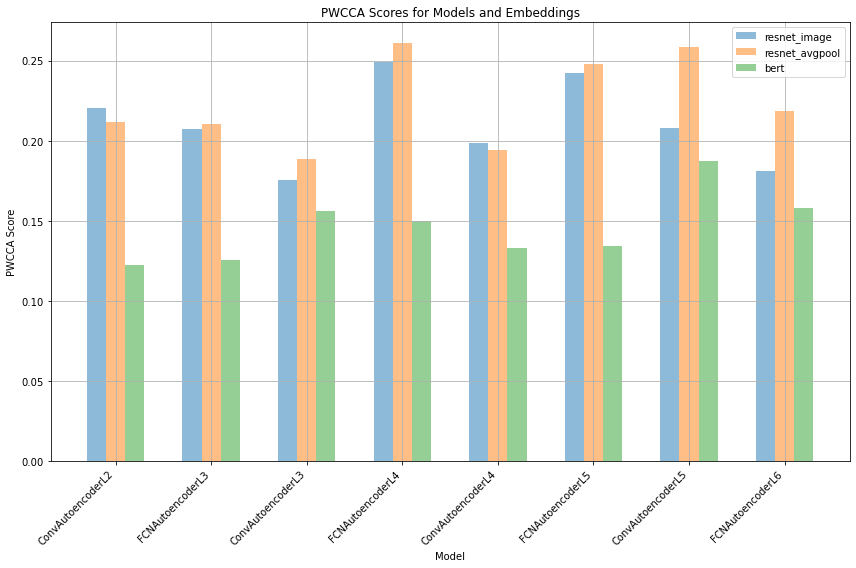

In [37]:
plt.figure(figsize=(12, 8))
x_indices = np.arange(len(pwcca_avg['index']))
bar_width = 0.2

for i, column in enumerate(pwcca_avg.columns[1:]):
    plt.bar(x_indices + i * bar_width, pwcca_avg[column], width=bar_width, alpha=0.5, label=column)
plt.xlabel('Model')
plt.ylabel('PWCCA Score')
plt.title('PWCCA Scores for Models and Embeddings')
plt.xticks(x_indices + (len(pwcca_avg.columns[1:]) - 1) * bar_width / 2, pwcca_avg['index'], rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

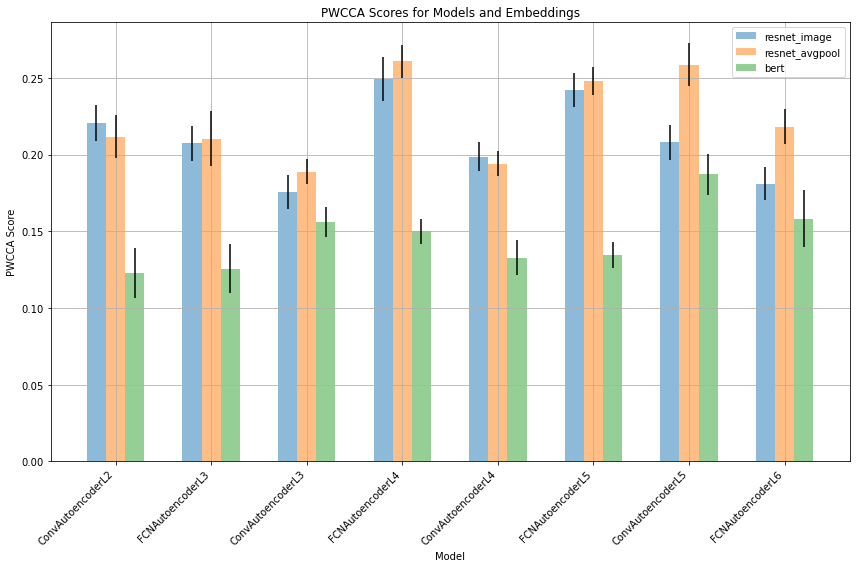

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have pwcca_avg and pwcca_std DataFrames

plt.figure(figsize=(12, 8))
x_indices = np.arange(len(pwcca_avg['index']))
bar_width = 0.2

for i, column in enumerate(pwcca_avg.columns[1:]):
    plt.bar(x_indices + i * bar_width, pwcca_avg[column], width=bar_width, alpha=0.5, label=column, yerr=pwcca_std[column])
    # yerr=pwcca_std[column] adds the std bars to the plot

plt.xlabel('Model')
plt.ylabel('PWCCA Score')
plt.title('PWCCA Scores for Models and Embeddings')
plt.xticks(x_indices + (len(pwcca_avg.columns[1:]) - 1) * bar_width / 2, pwcca_avg['index'], rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


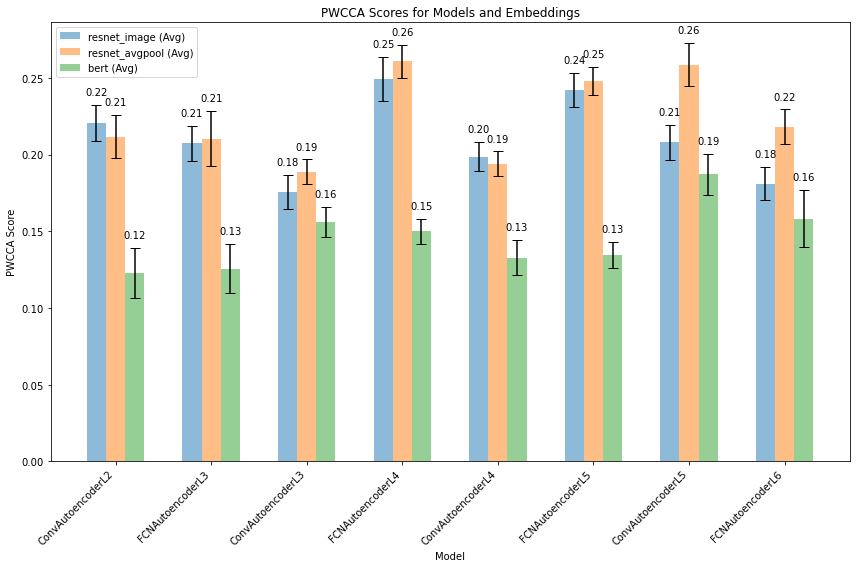

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have pwcca_avg and pwcca_std DataFrames




In [15]:
pwcca_df = pwcca_df.T

In [16]:
plt.figure(figsize=(12, 8))
x_indices = np.arange(len(pwcca_df['index']))
bar_width = 0.2

for i, column in enumerate(pwcca_df.columns[1:]):
    plt.bar(x_indices + i * bar_width, pwcca_df[column], width=bar_width, alpha=0.5, label=column)
plt.xlabel('Model')
plt.ylabel('PWCCA Score')
plt.title('PWCCA Scores for Models and Embeddings')
plt.xticks(x_indices + (len(pwcca_df.columns[1:]) - 1) * bar_width / 2, pwcca_df['index'], rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: 'index'

<Figure size 864x576 with 0 Axes>